### Imports and cluster environment

In [1]:
import multiprocessing
import pandas as pd
from sim.model import elfi_sim
from sim.sum_stats import elfi_summary
import tskit
import allel
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import elfi
import scipy.stats
from sklearn.preprocessing import StandardScaler
import graphviz

import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

#multiprocessing.freeze_support()
#elfi.set_client('multiprocessing')



### Create pseudo-observed data

In [2]:
y_obs = elfi_sim(length=int(5e6),
            recombination_rate=1.8e-8,
            mutation_rate=6e-8,
            pop_size_domestic_1=[100],
            pop_size_wild_1=[100],
            pop_size_captive=[100],
            captive_time=[20],
            mig_rate_captive=[0.01],
            mig_length_wild=[20],
            mig_rate_wild=[0.01],
            pop_size_domestic_2=[100],
            pop_size_wild_2=[100],
            div_time=[20000],
            mig_rate_post_split=[0.1],
            mig_length_post_split=[1000],
            bottleneck_time_wild=[3000],
            bottleneck_strength_wild=[10000],
            bottleneck_time_domestic=[3000],
            bottleneck_strength_domestic=[3000],
            random_state=np.random.RandomState(3),
            batch_size=1)

### Set up prior and constants

In [3]:
"""
length = elfi.Constant(int(5e6))
recombination_rate = elfi.Constant(1.8e-8)
mutation_rate = elfi.Constant(6e-8)
pop_size_domestic_1 = elfi.Prior(scipy.stats.uniform, 100, 10000-100)  # scipy.stats.uniform(100, 15000),
pop_size_wild_1 = elfi.Prior(scipy.stats.lognorm, 0.4, 0, np.exp(8))  # scipy.stats.lognorm(0.4, scale=np.exp(8.5)),
pop_size_captive = elfi.Prior(scipy.stats.lognorm, 0.3, 0, np.exp(4.5))
mig_rate_captive = elfi.Prior(scipy.stats.beta, 1.2, 40)
captive_time = elfi.Prior(scipy.stats.lognorm, 0.7, 0, np.exp(3))
mig_length_wild = elfi.Prior(scipy.stats.lognorm, 0.7, 0, np.exp(3))
mig_rate_wild = elfi.Prior(scipy.stats.beta(2, 50))              
pop_size_domestic_2 = elfi.Prior(scipy.stats.uniform, 1000, 20000-1000)  # scipy.stats.uniform(1000, 25000),
pop_size_wild_2 = elfi.Prior(scipy.stats.lognorm, 0.2, 0, np.exp(8.8))  # scipy.stats.lognorm(0.2, scale=np.exp(9.2)),
bottleneck_strength_domestic = elfi.Prior(scipy.stats.uniform, 0, 40000-0)
bottleneck_time_domestic = elfi.Prior(scipy.stats.norm, 3500, 600)
bottleneck_strength_wild = elfi.Prior(scipy.stats.uniform, 0, 40000-0)
bottleneck_time_wild = elfi.Prior(scipy.stats.norm, 3500, 600)
mig_length_post_split = elfi.Prior(scipy.stats.uniform, 0, 10000-0)
mig_rate_post_split = elfi.Prior(scipy.stats.truncnorm, 0, 1, 0, 0.1)
div_time = elfi.Prior(scipy.stats.norm, 40000, 5000)
"""
pass

In [4]:
# Test priors
length = elfi.Constant(int(5e6))
recombination_rate = elfi.Constant(1.8e-8)
mutation_rate = elfi.Constant(6e-8)
pop_size_domestic_1 = elfi.Prior(scipy.stats.truncnorm(-2, np.inf, 60, 10))  # scipy.stats.uniform(100, 15000),
pop_size_wild_1 = elfi.Prior(scipy.stats.truncnorm(-2, np.inf, 60, 10))  # scipy.stats.lognorm(0.4, scale=np.exp(8.5)),
pop_size_captive = elfi.Prior(scipy.stats.truncnorm(-2, np.inf, 60, 10))
mig_rate_captive = elfi.Prior(scipy.stats.beta, 1.2, 40)
captive_time = elfi.Prior(scipy.stats.lognorm, 0.7, 0, np.exp(3))
mig_length_wild = elfi.Prior(scipy.stats.lognorm, 0.7, 0, np.exp(3))
mig_rate_wild = elfi.Prior(scipy.stats.beta(2, 50))              
pop_size_domestic_2 = elfi.Prior(scipy.stats.truncnorm(-2, np.inf, 60, 10))  # scipy.stats.uniform(1000, 25000),
pop_size_wild_2 = elfi.Prior(scipy.stats.truncnorm(-2, np.inf, 60, 10))  # scipy.stats.lognorm(0.2, scale=np.exp(9.2)),
bottleneck_strength_domestic = elfi.Prior(scipy.stats.uniform, 0, 3000-0)
bottleneck_time_domestic = elfi.Prior(scipy.stats.norm, 3500, 300)
bottleneck_strength_wild = elfi.Prior(scipy.stats.uniform, 0, 3000-0)
bottleneck_time_wild = elfi.Prior(scipy.stats.norm, 3500, 300)
mig_length_post_split = elfi.Prior(scipy.stats.uniform, 0, 10000-0)
mig_rate_post_split = elfi.Prior(scipy.stats.truncnorm, 0, 1, 0, 0.1)
div_time = elfi.Prior(scipy.stats.norm, 20000, 1000)

### Initiate simulator node

In [5]:
y = elfi.Simulator(elfi_sim,
                   length, recombination_rate, mutation_rate, pop_size_domestic_1, pop_size_wild_1,
                   pop_size_captive, mig_rate_captive, mig_length_wild, mig_rate_wild,
                   captive_time, pop_size_domestic_2, pop_size_wild_2, div_time, mig_rate_post_split,
                   mig_length_post_split, bottleneck_time_wild, bottleneck_strength_wild,
                   bottleneck_time_domestic, bottleneck_strength_domestic, name="simulator", observed=y_obs)
s = elfi.Summary(elfi_summary, y, True, name='s')

d = elfi.Distance('euclidean', s, name='d')


In [6]:
logging.getLogger().setLevel(logging.DEBUG)
s.generate(1).shape

DEBUG:elfi.compiler:OutputCompiler compiling...
DEBUG:elfi.compiler:ObservedCompiler compiling...
DEBUG:elfi.compiler:AdditionalNodesCompiler compiling...
DEBUG:elfi.compiler:RandomStateCompiler compiling...
DEBUG:elfi.compiler:ReduceCompiler compiling...
DEBUG:elfi.executor:Executing _random_state
DEBUG:elfi.executor:Executing bottleneck_strength_domestic
DEBUG:elfi.executor:Executing bottleneck_strength_wild
DEBUG:elfi.executor:Executing bottleneck_time_domestic
DEBUG:elfi.executor:Executing bottleneck_time_wild
DEBUG:elfi.executor:Executing captive_time
DEBUG:elfi.executor:Executing div_time
DEBUG:elfi.executor:Executing mig_length_post_split
DEBUG:elfi.executor:Executing mig_length_wild
DEBUG:elfi.executor:Executing mig_rate_captive
DEBUG:elfi.executor:Executing mig_rate_post_split
DEBUG:elfi.executor:Executing mig_rate_wild
DEBUG:elfi.executor:Executing pop_size_captive
DEBUG:elfi.executor:Executing pop_size_domestic_1
DEBUG:elfi.executor:Executing pop_size_domestic_2
DEBUG:elfi.e

FileNotFoundError: In executing node 'simulator': [WinError 2] The system cannot find the file specified: '../output/decap_1044358133.trees'.

### Carry out simulations to "train" scaler

In [12]:
seed = 1
pool = elfi.OutputPool(['s'])
rej = elfi.Rejection(d, batch_size=4, seed=1, pool=pool)
rej_res = rej.sample(32, quantile=1)  # Accept all
store = pool.get_store('s')
sum_stats = np.array(list(store.values()))
sum_stats = sum_stats.reshape(-1, sum_stats.shape[2])  # Drop batches axis
scaler = StandardScaler() # StandardScaler()
scaler.fit(sum_stats)

 C:\Users\Danie\OneDrive\Documents\wildcats_summer\scripts\sim\sum_stats.py:293: UserWarning:Some summaries removed to keep things quick!


Progress: |██████████████████████████████████████████████████| 100.0% Complete


StandardScaler()

### Test scaling params

In [13]:
# New priors
length.become(elfi.Constant(int(5e6)))
recombination_rate.become(elfi.Constant(1.8e-8))
mutation_rate.become(elfi.Constant(6e-8))
pop_size_domestic_1.become(elfi.Prior(scipy.stats.uniform, -1, 2))  # scipy.stats.uniform(100, 15000),
pop_size_wild_1.become(elfi.Prior(scipy.stats.uniform, -1, 2))  # scipy.stats.lognorm(0.4, scale=np.exp(8.5)),
pop_size_captive.become(elfi.Prior(scipy.stats.uniform, -1, 2))
mig_rate_captive.become(elfi.Prior(scipy.stats.uniform, -1, 2))
captive_time.become(elfi.Prior(scipy.stats.uniform, -1, 2))
mig_length_wild.become(elfi.Prior(scipy.stats.uniform, -1, 2))
mig_rate_wild.become(elfi.Prior(scipy.stats.uniform, -1, 2))           
pop_size_domestic_2.become(elfi.Prior(scipy.stats.uniform, -1, 2))  # scipy.stats.uniform(1000, 25000),
pop_size_wild_2.become(elfi.Prior(scipy.stats.uniform, -1, 2))  # scipy.stats.lognorm(0.2, scale=np.exp(9.2)),
bottleneck_strength_domestic.become(elfi.Prior(scipy.stats.uniform, -1, 2))
bottleneck_time_domestic.become(elfi.Prior(scipy.stats.uniform, -1, 2))
bottleneck_strength_wild.become(elfi.Prior(scipy.stats.uniform, -1, 2))
bottleneck_time_wild.become(elfi.Prior(scipy.stats.uniform, -1, 2))
mig_length_post_split.become(elfi.Prior(scipy.stats.uniform, -1, 2))
mig_rate_post_split.become(elfi.Prior(scipy.stats.uniform, -1, 2))
div_time.become(elfi.Prior(scipy.stats.uniform, -1, 2))

In [ ]:
param_scaler = StandardScaler()
param_scaler.fit(rej_res.samples_array)

def elfi_sim_scaled(*args, batch_size, random_state):
    constants = args[:3]
    params = np.array(args[3:]).T
    params_with_priors = param_scaler.inverse_transform(params).T.tolist()

    results = elfi_sim(*args[:3], *params_with_priors, random_state, batch_size)
    return results



y.become(elfi.Simulator(elfi_sim_scaled,
                   length, recombination_rate, mutation_rate, pop_size_domestic_1, pop_size_wild_1,
                   pop_size_captive, mig_rate_captive, mig_length_wild, mig_rate_wild,
                   captive_time, pop_size_domestic_2, pop_size_wild_2, div_time, mig_rate_post_split,
                   mig_length_post_split, bottleneck_time_wild, bottleneck_strength_wild,
                   bottleneck_time_domestic, bottleneck_strength_domestic, name="simulator_scaled", observed=y_obs))

### Scale summaries

In [14]:
def elfi_summary_scaled(*args):  # This function might not get pushed to workers properly?
    sum_stats = elfi_summary(*args)
    sum_stats = scaler.transform(sum_stats)
    return sum_stats

s.become(elfi.Summary(elfi_summary_scaled, y, name='scaled_s'))

In [ ]:
''

### Test tutorial smc scaling

In [1]:
import elfi
import scipy.stats
import numpy as np

In [2]:
from elfi.examples import ma2
ma2_model = ma2.get_model()

In [3]:
ma2_model['t1'].become(elfi.Prior(scipy.stats.uniform(loc=0, scale=2), model=ma2_model))
ma2_model['t2'].become(elfi.Prior(scipy.stats.uniform(loc=0, scale=2), model=ma2_model))

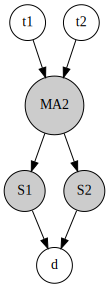

In [4]:
elfi.draw(ma2_model)

In [5]:
smc = elfi.SMC(ma2_model['d'], batch_size=10000, seed=1)
N = 1000
schedule = [0.7, 0.2, 0.05]
result_smc = smc.sample(N, schedule)
result_smc.summary(all=True)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Method: SMC
Number of samples: 1000
Number of simulations: 140000
Threshold: 0.0482
Sample means: t1: 0.761, t2: 0.267

Population 0:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 10000
Threshold: 0.445
Sample means: t1: 0.735, t2: 0.347

Population 1:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 20000
Threshold: 0.162
Sample means: t1: 0.761, t2: 0.259

Population 2:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 110000
Threshold: 0.0482
Sample means: t1: 0.761, t2: 0.267


In [8]:
# Mess up scaling in prior, then scale down in simulator
scale = 10
ma2_model['t1'].become(elfi.Prior(scipy.stats.uniform, 0, 2*scale, model=ma2_model))


def MA2(t1, t2, extra_kw="defualt", n_obs=100, batch_size=1, random_state=None):
    print(extra_kw)
    t1=t1/scale
    t1 = np.asanyarray(t1).reshape((-1, 1))
    t2 = np.asanyarray(t2).reshape((-1, 1))
    random_state = random_state or np.random

    w = random_state.randn(batch_size, n_obs+2)  # i.i.d. sequence ~ N(0,1)
    x = w[:, 2:] + t1*w[:, 1:-1] + t2*w[:, :-2]
    return x

ma2_model['MA2'].become(elfi.Simulator(MA2, ma2_model['t1'], ma2_model['t2'], "NON DEFUALT",  observed=ma2_model.observed["MA2"], model=ma2_model))

In [9]:
smc = elfi.SMC(ma2_model['d'], batch_size=10000, seed=3)
N = 1000
schedule = [0.7, 0.2, 0.05]
result_smc = smc.sample(N, schedule)
result_smc.summary()

NON DEFUALT--------------------------------------------------| 0.0% Complete
NON DEFUALT█████████████████████████-------------------------| 50.0% Complete
NON DEFUALT█████████████████████████████████-----------------| 66.7% Complete
NON DEFUALT█████████████████████████████████████-------------| 75.0% Complete
NON DEFUALT█████████████-------------------------------------| 26.7% Complete
NON DEFUALT█████████████████---------------------------------| 35.7% Complete
NON DEFUALT█████████████████████-----------------------------| 42.9% Complete
NON DEFUALT█████████████████████████-------------------------| 50.0% Complete
NON DEFUALT████████████████████████████----------------------| 57.1% Complete
NON DEFUALT████████████████████████████████------------------| 64.3% Complete
NON DEFUALT███████████████████████████████████---------------| 71.4% Complete
NON DEFUALT███████████████████████████████████████-----------| 78.6% Complete
NON DEFUALT██████████████████████████████████████████--------| 85

This tutorial example starts to fail when the difference in scales is around 1 million times. Perhaps we need to scale the parameters too!